In [1]:
!pip install -q sentence-transformers pandas scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 51.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 34.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 36.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 87.5 MB/s eta 0:00:00


## Семантическое сопоставление на основе эмбеддингов

In [2]:
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm
import pandas as pd
import numpy as np

In [ ]:
!ls

sample_data


In [4]:
students = pd.read_json("hse_students_combined_50.json").iloc[:20]
projects = pd.read_json("hse_all_projects.json").iloc[:20]
matches = pd.read_json("student_project_manual_matching_top20.json")

In [5]:
def format_student(row):
    interests = ", ".join(row["Научные интересы (Фолксономия)"])
    return f"Интересы: {interests}. О себе: {row['Рассказ о себе']}"

students["text"] = students.apply(format_student, axis=1)

# Текстовое представление проектов
def format_project(row):
    return f"{row['Название проекта']}. {row['Описание проекта']} Сроки: {row['Сроки исполнения']}"

projects["text"] = projects.apply(format_project, axis=1)

In [6]:
students["GPA_norm"] = (students["GPA"] - 6) / 4

### Сравнение моделей

In [10]:
models = [
    "all-MiniLM-L6-v2",
    "all-mpnet-base-v2",
    "paraphrase-MiniLM-L12-v2",
    "cointegrated/rubert-tiny"
]

In [19]:
def precision_at_3(similarity_matrix, students, projects, matches):
    precisions = []
    for i, fio in enumerate(students["ФИО"]):
        top_3_indices = similarity_matrix[i].argsort()[-3:][::-1]
        top_3_projects = [projects[j] for j in top_3_indices]
        gt = matches[matches["ФИО"] == fio][["1-й проект", "2-й проект", "3-й проект"]].values.flatten().tolist()
        num_relevant = sum(1 for p in top_3_projects if p in gt)
        precisions.append(num_relevant / 3)
    return np.mean(precisions)

In [ ]:
results = {}

for model_name in models:
    print(f"\n🔍 Модель: {model_name}")
    model = SentenceTransformer(model_name)

    student_embeddings = model.encode(students["text"], show_progress_bar=True, convert_to_numpy=True)
    project_embeddings = model.encode(projects["text"], show_progress_bar=True, convert_to_numpy=True)

    similarity_matrix = cosine_similarity(student_embeddings, project_embeddings)

    p3 = precision_at_3(similarity_matrix, students, projects["Название проекта"].tolist(), matches)
    results[model_name] = round(p3, 3)

In [22]:
print("\n Итоговое сравнение моделей (Precision@3):")
for model, score in results.items():
    print(f"{model}: {score}")


 Итоговое сравнение моделей (Precision@3):
all-MiniLM-L6-v2: 0.234
all-mpnet-base-v2: 0.266
paraphrase-MiniLM-L12-v2: 0.166
cointegrated/rubert-tiny: 0.466


### Кластеризация эмбедингов

In [23]:
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist

In [24]:
def simplify_label(tags):
    return tags[0] if tags else "Не указано"
students["label"] = students["Научные интересы (Фолксономия)"].apply(simplify_label)

In [25]:
distance_matrix = pdist(project_embeddings, metric='cosine')
linkage_matrix = linkage(distance_matrix, method='ward')

In [26]:
project_names = projects["Название проекта"].tolist()

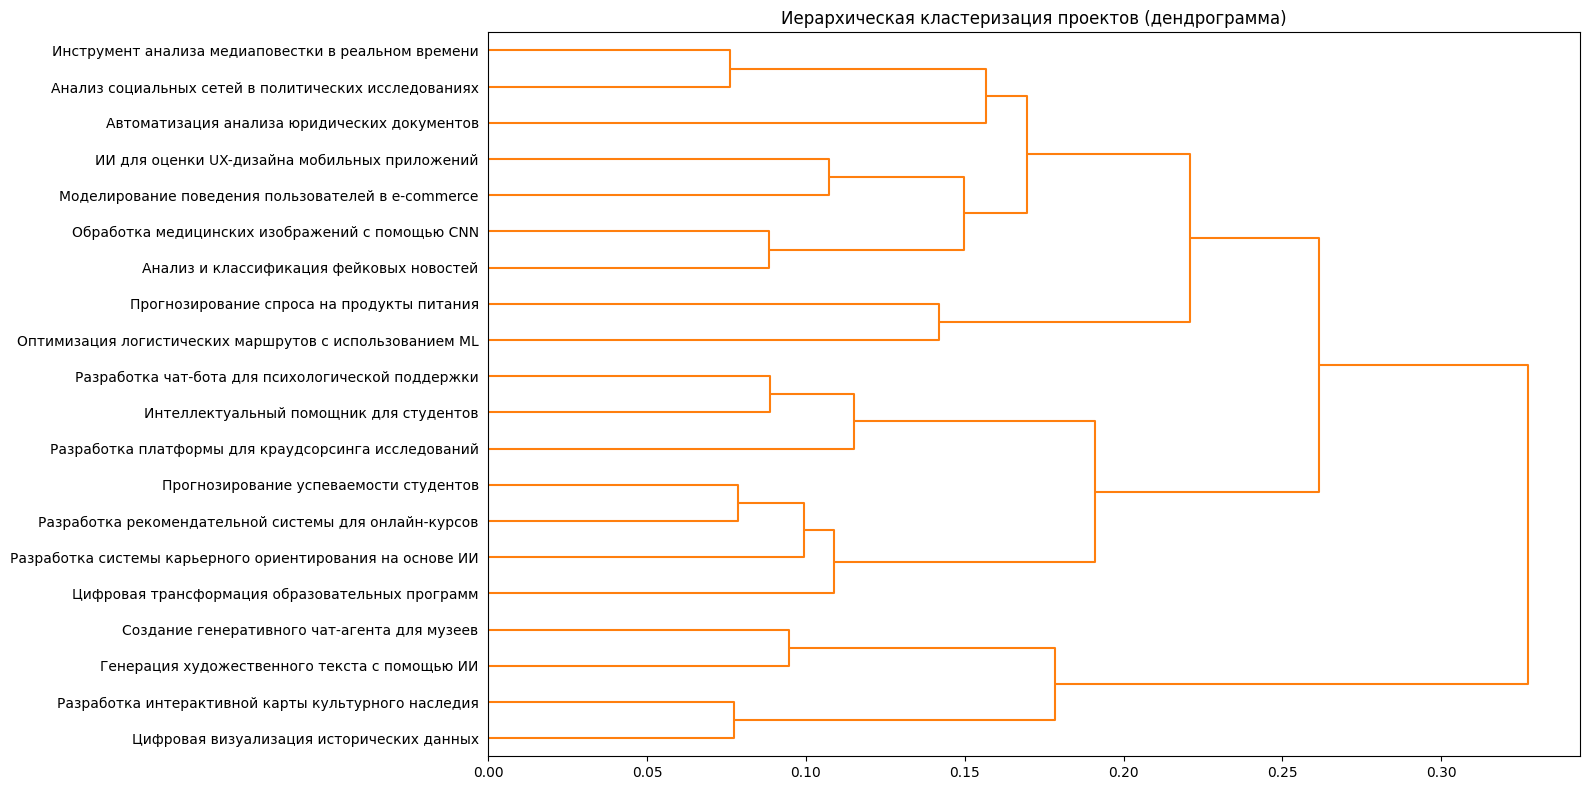

In [27]:
plt.figure(figsize=(16, 8))
dendrogram(linkage_matrix, labels=project_names, orientation='right', leaf_font_size=10, color_threshold=1.0)
plt.title("Иерархическая кластеризация проектов (дендрограмма)")
plt.tight_layout()
plt.show()

### Использвание cross-encoder

In [ ]:
from sentence_transformers import CrossEncoder

In [ ]:
model = CrossEncoder('cointegrated/rubert-tiny')

# Формирование всех пар (студент, проект)
pairs = []
pair_indices = []
for i, s_text in enumerate(students["text"]):
    for j, p_text in enumerate(projects["text"]):
        pairs.append([s_text, p_text])
        pair_indices.append((i, j))  # сохранить соответствие индексов

In [ ]:
scores = model.predict(pairs, show_progress_bar=True)

In [ ]:
num_students = len(students['text'])
num_projects = len(projects['text'])
similarity_matrix = np.zeros((num_students, num_projects))

for idx, score in zip(pair_indices, scores):
    similarity_matrix[idx[0], idx[1]] = score

In [ ]:
p3 = precision_at_3(similarity_matrix, students, projects["Название проекта"].tolist(), matches)

print(f"\n Precision@3 (Cross-Encoder): {p3:.3f}")


 Precision@3 (Cross-Encoder): 0.200
